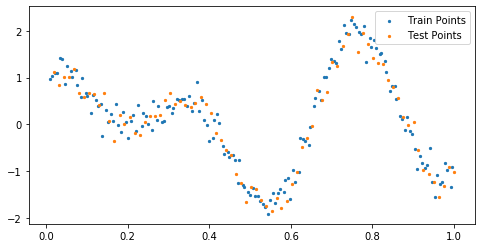

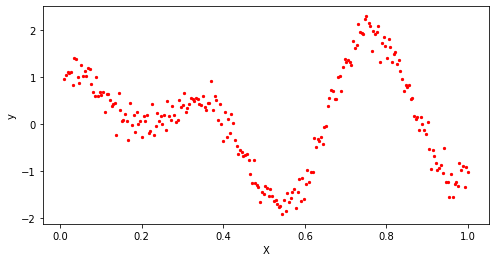

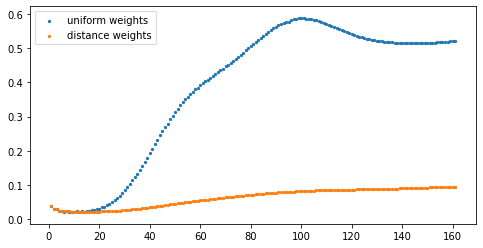

MSE of uniform models is 0.0206%  with k=10
MSE of uniform models is 0.0216%  with k=14


In [6]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split


def predict(X, y, d_X, n_neighbors, metric, weights, do_normalize=False):
    if isinstance(X, pd.core.series.Series):
        X = X.to_numpy()

    if isinstance(y, pd.core.series.Series):
        y = y.to_numpy()

    y = y.reshape(-1, 1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    if isinstance(d_X, pd.core.series.Series):
        d_X = d_X.to_numpy()

    if d_X.ndim == 1:
        d_X = d_X.reshape(-1, 1)

    if do_normalize:
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0) + 1e-7
        d_X = (d_X - X_mean) / X_std

    distances = compute_distances(X, metric, d_X)

    arg_sorted_labels = np.argsort(distances, axis=1)
    knn_weights = np.power(np.sort(distances, axis=1)[:, :n_neighbors] + 1e-7, -1)
    knn_labels = y[arg_sorted_labels].reshape(arg_sorted_labels.shape)[:, :n_neighbors]

    if weights is 'uniform':
        predictions = knn_labels.mean(axis=1)

    if weights is 'distance':
        predictions = np.multiply(knn_labels, knn_weights).sum(axis=1) / knn_weights.sum(axis=1)

    return predictions


def compute_distances(X, metric, d_X):
    if isinstance(X, pd.core.series.Series):
        X = X.to_numpy()
    along_axis_diffs = d_X[:, np.newaxis, :] - X
    if metric is 'chebyshev':
        distances = np.abs(along_axis_diffs).max(axis=-1)
    if metric is 'minkowski':
        distances = np.power(np.power(np.abs(along_axis_diffs), 2).sum(axis=-1), 1 / 2)
    if metric is 'manhattan':
        distances = np.abs(along_axis_diffs).sum(axis=-1)


    return distances


def MSE(y_pred, gt):
    return (1 / (2 * len(gt))) * np.power(y_pred - gt, 2).sum()


df = pd.read_csv('regression.txt', header=None)
df.columns = ['X', 'y']

X_train = df.loc[df.index % 3 != 2, 'X']
y_train = df.loc[df.index % 3 != 2, 'y']
X_test = df.loc[df.index % 3 == 2, 'X']
y_test = df.loc[df.index % 3 == 2, 'y']

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X_train, y_train, s=5, label='Train Points')
ax.scatter(X_test, y_test, s=5, label='Test Points')
ax.legend(loc=0)
plt.show()

ax = df.plot(kind='scatter', x='X', y='y', s=5, figsize=(8, 4), color='red')
plt.show()

errors_uniform = []
errors_distance = []
weights = ['uniform', 'distance']
n_neighbors = range(1, 162)

for n_neighbor in n_neighbors:
    for weight in weights:
        predicts = predict(X_train, y_train, X_test, n_neighbors=n_neighbor, metric='minkowski',
                           weights=weight, do_normalize=False)
        error = MSE(predicts, y_test)

        if weight in 'uniform':
            errors_uniform.append(error)
        else:
            errors_distance.append(error)

errors_uniform = np.asarray(errors_uniform)
errors_distance = np.asarray(errors_distance)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1, 162), errors_uniform, label='uniform weights', s=5)
ax.scatter(range(1, 162), errors_distance, label='distance weights', s=5)
ax.legend()
plt.show()

print(f'MSE of uniform models is {np.min(errors_uniform):.4f}% \
 with k={n_neighbors[np.argmin(errors_uniform)]}')
print(f'MSE of uniform models is {np.min(errors_distance):.4f}% \
 with k={n_neighbors[np.argmin(errors_distance)]}')
